# Assess Transects Across Urban Areas in Cases Studies
by Cascade Tuholske March, 2021

In [1]:
import rasterio 
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio.mask
import glob
from matplotlib import colors, cm
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

In [2]:
# Path
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
city_nm ='Beira' # always update

In [3]:
# Fun colors
# https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

## Clip Match Rasters

In [4]:
def raster_clip(rst_fn, polys, in_ext, out_ext):
    
    """ function clips a raster and saves it out
    args:
        rst_fn = raster you want to clip
        polys = polys you want to clip to
        in_ext = tail of .tif file to clip off
        out_ext = tail of .tif file for saving out 
    """
    
    # Get raster name
    data = rst_fn.split(DATA_PATH+'interim/')[1].split(in_ext)[0]
    fn_out = DATA_PATH+'interim/'+data+out_ext
    print(fn_out)
    
    # clip raster
    with rasterio.open(rst_fn) as src:
        out_image, out_transform = rasterio.mask.mask(src, polys, crop=True)
        out_meta = src.meta
        
    # Update meta data
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(out_image)

In [5]:
#### Matched Rasters 
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*_matched.tif')
rst_fns

# Open point and buffer
point_fn = DATA_PATH+'interim/UCDB-'+city_nm+'.shp'
point = gpd.read_file(point_fn)

# CRS is in degrees, but we're going with ~km here so (.25° ~  55.5km)
dist = .25
buffer = point.buffer(dist, cap_style = 3)

in_ext = '_matched.tif'
out_ext = '_'+city_nm+'.tif'
for rst_fn in rst_fns:
    raster_clip(rst_fn, buffer, in_ext, out_ext)

/Users/cascade/Github/PopGridCompare/data/interim/GHS15_Beira.tif
/Users/cascade/Github/PopGridCompare/data/interim/LS15_Beira.tif
/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_Beira.tif
/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_Beira.tif
/Users/cascade/Github/PopGridCompare/data/interim/WP16_Beira.tif


<ipython-input-5-b1a5bedec429>:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = point.buffer(dist, cap_style = 3)


## Clip MGUP

In [6]:
def raster_clip(rst_fn, polys, fn_out):
    
    """ function clips a raster and saves it out
    args:
        rst_fn = raster you want to clip
        poly = polys you want to clip to
        fn_out = fn to write out
    """
    
    
    # clip raster
    with rasterio.open(rst_fn) as src:
        out_image, out_transform = rasterio.mask.mask(src, polys, crop=True)
        out_meta = src.meta
        
    # Update meta data
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(out_image)

In [7]:
#### MGUP
rst_fn = DATA_PATH+'interim/MGUP15_2015-km-matched.tif'
fn_out = DATA_PATH+'interim/MGUP15_2015-km-'+city_nm+'.tif'
raster_clip(rst_fn, buffer, fn_out)

## Make plot data

In [8]:
#### set colors
ESRI16_c = 'blue'
GHS15_c = 'indigo'
GPWv4_c = 'deeppink'
LS15_c = 'deepskyblue'
WP16_c = 'forestgreen'

In [9]:
clip_rsts = sorted(glob.glob(DATA_PATH+'interim/*_'+city_nm+'.tif'))

In [10]:
# Make a ~60km transect
def make_transect(rst_fns):
    dic = {}
    df = pd.DataFrame()
    
    # pop
    for rst in clip_rsts:
        
        data = rst.split(DATA_PATH+'interim/')[1].split('_'+city_nm+'.tif')[0] # get data str
        print(data)
        arr = rasterio.open(rst).read(1) # read in array
        sub = arr[28:34,:] # subset 7 X 61km transect
        sub = np.where(sub == -999, 0, sub) # revalue
        df[data] = sub.sum(axis = 0) # populatate array
        
        # log scale it for the dic
        sub = res = np.where(sub != 0, np.log10(sub), 0) 
        dic[data] = sub

    
    return dic, df

In [11]:
dic, df = make_transect(clip_rsts)

ESRI16
GHS15
GPWv4
LS15
WP16


<ipython-input-10-d81cb8b508c8>:17: RuntimeWarning: divide by zero encountered in log10
  sub = res = np.where(sub != 0, np.log10(sub), 0)


In [12]:
# get color ranges for min max
for i, item in enumerate(dic.items()):
    print(item[0], item[1].max(), item[1].min())

ESRI16 4.4177705311169255 0.0
GHS15 4.207209313406194 0.0
GPWv4 2.7628157 0.0
LS15 4.5677907105335365 0.0
WP16 3.7903967 0.0


In [13]:
vmax = 4.5

In [14]:
# rename them 
dic['WPE-16'] = dic.pop('ESRI16')
dic['GHS-15'] = dic.pop('GHS15')
dic['GPW-15'] = dic.pop('GPWv4')
dic['LS-15'] = dic.pop('LS15')
dic['WP-16'] = dic.pop('WP16')

In [15]:
# mgup data 
fn_in = DATA_PATH+'interim/MGUP15_2015-km-'+city_nm+'.tif'
mgup = rasterio.open(fn_in).read(1)
mgup_data = mgup[28:34,:]

## Raster plots

In [16]:
# Make colors
hex_list = ['#0091ad', '#3fcdda', '#83f9f8', '#d6f6eb', '#fdf1d2', '#f8eaad', '#faaaae', '#ff57bb']
newcmp=get_continuous_cmap(hex_list)

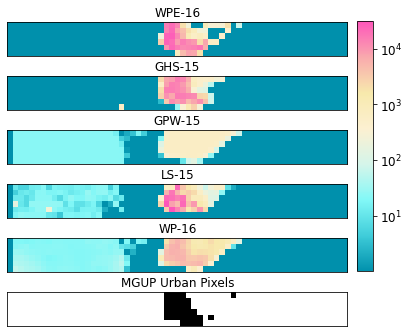

In [17]:
# plot transects
fig, axs = plt.subplots(6, 1, figsize = (7, 12), sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=.5, wspace=0, hspace=0)

# color map
# Make colors
hex_list = ['#0091ad', '#3fcdda', '#83f9f8', '#d6f6eb', '#fdf1d2', '#f8eaad', '#faaaae', '#ff57bb']
newcmp=get_continuous_cmap(hex_list)

# pop
for i, key in enumerate(dic):
    
    im = axs[i].imshow(dic[key], alpha = 1, cmap = newcmp, vmin = 0, vmax = vmax)
    axs[i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelleft=False, 
                       labelbottom=False)
    axs[i].set_title(key)

# mgup
data = np.where(mgup_data == -999, 0, mgup_data)
axs[5].imshow(mgup_data, cmap = 'binary')
axs[5].set_title('MGUP Urban Pixels')
axs[5].tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelleft=False, 
                       labelbottom=False)

# color bar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.2, 0.03, 0.29])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_ticks([1,2,3,4])
cb.set_ticklabels(['$10^1$', '$10^2$', '$10^3$', '$10^4$'])
cbar_ax.tick_params(labelsize=12)

# color bar ticks
# cbar_ax.set_xticks([0,3])

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Fig3-'+city_nm+'-rst.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

## Line plot sums

<ipython-input-18-ff682a27b3f0>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(labels, fontsize = 13)
<ipython-input-18-ff682a27b3f0>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(labels, fontsize = 13)
<ipython-input-18-ff682a27b3f0>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(labels, fontsize = 13)
<ipython-input-18-ff682a27b3f0>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_yticklabels(labels, fontsize = 13)
<ipython-input-18-ff682a27b3f0>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[4].set_yticklabels(labels, fontsize = 13)


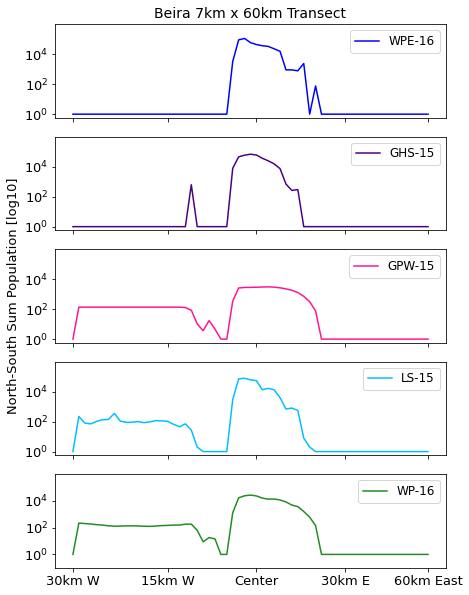

In [18]:
# Make  plot 
fig, axs = plt.subplots(5, 1, figsize = (7, 10), sharex=True)
#fig.subplots_adjust(left=None, bottom=None, right=None, top=.5, wspace=0, hspace=0)
ws = 0.25
fig.subplots_adjust(wspace=ws)
x = list(range(0,61))
scale = 1

# Title & labels
axs[0].set_title(city_nm+' 7km x 60km Transect', fontsize = 14)
labels = ['$10^0$', '$10^2$', '$10^4$']
locs = [0,2,4]

# ESRI
data = np.ma.log10(df.ESRI16.to_numpy())
data = data.filled(0)
axs[0].plot(x, data, alpha  = 1, color = ESRI16_c)
axs[0].set_ylim([-0.25,6])
axs[0].legend(['WPE-16'], fontsize = 12, loc = 'upper right')
axs[0].set_yticklabels(labels, fontsize = 13)
axs[0].set_yticks(locs)

# GHS15
data = np.ma.log10(df.GHS15.to_numpy())
data = data.filled(0)
axs[1].plot(x, data, alpha  = 1, color = GHS15_c)
axs[1].set_ylim([-0.25,6])
axs[1].legend(['GHS-15'], fontsize = 12, loc = 'upper right')
axs[1].set_yticklabels(labels, fontsize = 13)
axs[1].set_yticks(locs)

# GPWv4
data = np.ma.log10(df.GPWv4.to_numpy())
data = data.filled(0)
axs[2].plot(x, data, alpha  = 1, color = GPWv4_c)
axs[2].set_ylim([-0.25,6])
axs[2].legend(['GPW-15'], fontsize = 12, loc = 'upper right')
axs[2].set_yticklabels(labels, fontsize = 13)
axs[2].set_yticks(locs)
axs[2].set_ylabel('North-South Sum Population [log10]', fontsize = 13)

# LS15
data = np.ma.log10(df.LS15.to_numpy())
data = data.filled(0)
axs[3].plot(x, data, alpha  = 1, color = LS15_c)
axs[3].set_ylim([-0.25,6])
axs[3].legend(['LS-15'], fontsize = 12, loc = 'upper right')
axs[3].set_yticklabels(labels, fontsize = 13)
axs[3].set_yticks(locs)

# WP-16
data = np.ma.log10(df.WP16.to_numpy())
data = data.filled(0)
axs[4].plot(x, data, alpha  = 1, color = WP16_c)
axs[4].set_ylim([-1,6])
axs[4].legend(['WP-16'], fontsize = 12, loc = 'upper right')
axs[4].set_yticklabels(labels, fontsize = 13)
axs[4].set_yticks(locs)

# Ticks
plt.xticks([0, 16, 31, 46, 60], ['30km W', '15km W', 'Center', '30km E', '60km East'], fontsize = 13);

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Fig3-'+city_nm+'-sums.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')